These 94 lines of code are everything that is needed to train a neural network. Everything else is just efficiency.

This is my earlier project Micrograd. It implements a scalar-valued auto-grad engine. You start with some numbers at the leafs (usually the input data and the neural network parameters), build up a computational graph with operations like + and * that mix them, and the graph ends with a single value at the very end (the loss). You then go backwards through the graph applying chain rule at each node to calculate the gradients. The gradients tell you how to nudge your parameters to decrease the loss (and hence improve your network).

Sometimes when things get too complicated, I come back to this code and just breathe a little. But ok ok you also do have to know what the computational graph should be (e.g. MLP -> Transformer), what the loss function should be (e.g. autoregressive/diffusion), how to best use the gradients for a parameter update (e.g. SGD -> AdamW) etc etc. But it is the core of what is mostly happening.

The 1986 paper from Rumelhart, Hinton, Williams that popularized and used this algorithm (backpropagation) for training neural nets:

https://x.com/karpathy/status/1803963383018066272

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

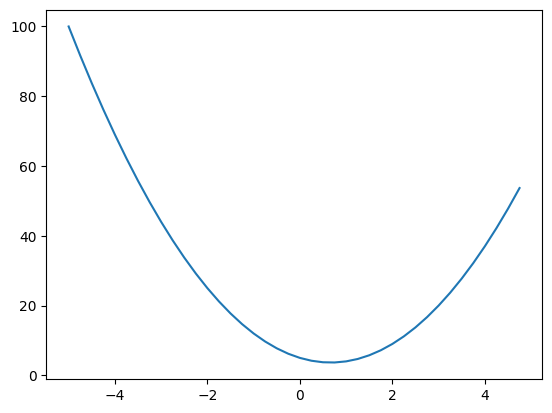

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# The derivative is the slope at a given point in a function
# It tells us how much a given function will increase or decrease in a given point

h = 0.0000000001
x = 3
(f(x + h) - f(x))/h

14.000001158365194

In [6]:
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.9999999997
slope -3.000000248221113


In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # Gradient of 0 means no effect
        # AKA changing the variable has no effect on the loss function
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # Allows us to do Value(2.0) + 1.0
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # Local deriv of addition is just 1.0
            # with chain rule we just multiply that times the subsequent 
            # Value's gradient.
            # Note gradients accumulate (in case values are used more than once
            # in a graph)
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # Local deriv of multiply is the other var we multiply by
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        # This is just a special python function that lets us also do
        # 2.0 * Value(3.0)
        return self * other
    
    def __truediv__(self, other): # self / other
        # This is another way to represent division
        return self * other**-1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        # The formula for tanh
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # Local deriv of tan (basically just from wikipedia)
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        # Here we just build a topological sort of the graph
        # This basically just orders all nodes start to finish, making sure
        # when we do backwards, we never hit a node before all of its dependencies were
        # visited
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [280]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [282]:
L.backward()

In [12]:

L._prev, L._op

({Value(data=-2.0), Value(data=4.0)}, '*')

In [223]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad % .4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

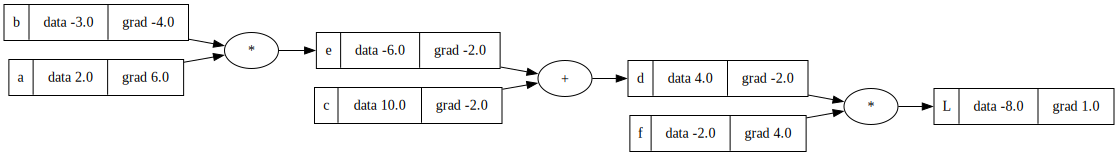

In [16]:
# We keep track of everything that happens to each value ("weight")
# because we want to know how much a change in each weight influences the
# loss function, aka their derivatives/gradients.
draw_dot(L)

L = d * f

dL / dd =? f

### Definition of a derivative
It is the limit as h goes to 0 of this expression of instanenous change.
This is a proof that shows how much L changes as h approaches 0.
It says that deriv of L with respect to d is just f.
Note that f() is "function" in calculus, but below that we are using f
the variable name.

(f(x + h) - f(x)) / h

((d+h)*f - d*f) / h

(d*f + h*f - d*f) / h

d*f cancels out

(h*f) / h

f


The most important variable to consider here is c.
If we know how much wiggling d affects L, how can we figure out how much
wiggling c affects L if there's another step?

It boils down to knowing how wiggling c affects d, and since we know how much 
d affects L, we can combine the two to know the final impact.

Get the derivative of d with respect to c.

dd / dc =? 1.0

d = c + e

(f(x+h) - f(x)) / h

((c+h)+e - (c+e)) / h

(c + h + e - c - e) / h

c and e cancel out

h / h = 1

Likewise, dd/de is also 1. So the derivative of a sum expression is very simple.

In calculus, [the chain rule](https://en.wikipedia.org/wiki/Chain_rule) indicates
that the derivative of L with respect to c is just the derivative of d with respect to c
times the derivative of L with respect to d. In other words, we just multiply 
the intermediate derivatives.

""If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

In our example then:

dL / dc = (dL / dd) * (dd / dc)

We already know dL/dd is -2, and we know dd/dc is 1, so dL/dc = -2 * 1 = -2

In [10]:
L.grad = 1
# By the definition above, f is just d
# and d is just f
f.grad = 4.0
d.grad = -2.0
# By chain rule
c.grad = -2.0 * 1
e.grad = -2.0 * 1
# Carry chain rule onward as we go backward
# Each node only knows its own local derivative, but you can deriv
# the complete deriv of the loss function using the chain rule
a.grad = (-2.0 * 1) * -3.0
b.grad = (-2.0 * 1) * 2.0

In [17]:
# Use gradient descent to step each variable in the direction of the gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Performing the forward pass again shows us we get a slightly improved loss function
e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [6]:
# This is the empirical way of determining the drivative of L with respect to
# one of the variables.
# In other words, we're actually incrementing a variable and recalculating L
# and its rate of change at that h.
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d'
    f = Value(-2.0 + h, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    # Derivative of L with respect to a
    # AKA rate of change of L when a is changed by small amount h
    print((L2 - L1) / h)

lol()

3.9999999999995595


In [12]:
# A more interesting/realistic neural net - 2 inputs and weights, a bias, and 
# an activation function, tanh

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

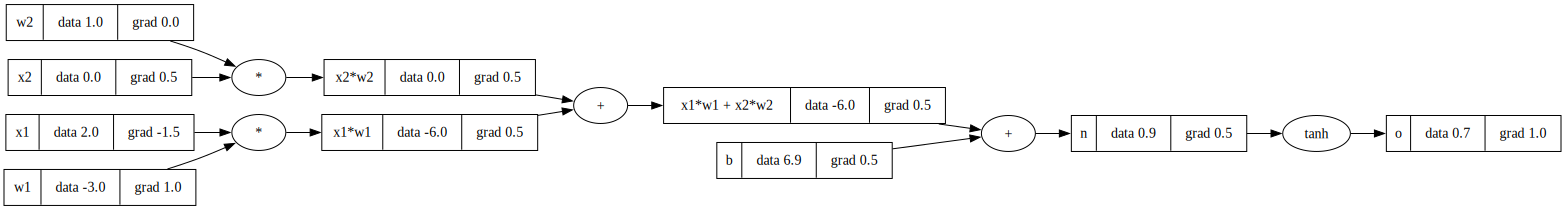

In [15]:
draw_dot(o)

In [14]:
o.backward()

In [92]:
class Neuron:
    def __init__(self, n_in: int):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x: list[Value] | list[float]):
        # This is just the sum of all inputs times all weights plus the bias.
        # w*x + b
        activation = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, n_in: int , n_out: int):
        # Creates a number of neurons based on the number of outputs we want
        # from the layer.
        # In a fully connected neural net, all outputs from the prior layers
        # are fed into each neuron as inputs.
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # To simplify, return just number instead of array if single item
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    """
    A MLP - MultiLayer Perceptron - is a fully connected feedforward neural
    network architecture.
    Understanding this architecture from scratch and in depth is a good 
    foundation for building up to more advanced ones like CNNs and RNNs.
    """
    def __init__(self, n_in: int, n_outs: list[int]):
        sz = [n_in] + n_outs
        # In a MLP, each layer's number of neurons is the size of the next
        # layer's input size.
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [43]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9852615397996309)

In [140]:
nn = MLP(3, [4, 4, 1])

In [141]:
nn.parameters()

[Value(data=0.2644066048462075),
 Value(data=0.43581390493039907),
 Value(data=-0.16324727468030664),
 Value(data=0.01731676059052001),
 Value(data=0.6604677642820267),
 Value(data=0.8102835108754238),
 Value(data=-0.27939006209170825),
 Value(data=-0.48518875140050666),
 Value(data=0.44872785290885475),
 Value(data=0.5440889479437285),
 Value(data=0.06353226506375753),
 Value(data=-0.8059184312478394),
 Value(data=-0.2173423165934556),
 Value(data=0.3075549298976572),
 Value(data=0.12879683965206246),
 Value(data=-0.12967076999746596),
 Value(data=0.8124852367297926),
 Value(data=0.2530536441093387),
 Value(data=0.17486074901519677),
 Value(data=0.4264468581281089),
 Value(data=0.5621978800829373),
 Value(data=0.0954082086688286),
 Value(data=0.41572324383589687),
 Value(data=0.15365063489638442),
 Value(data=-0.017702975953491018),
 Value(data=-0.5969557142447339),
 Value(data=-0.1433572689550986),
 Value(data=0.7823425676088649),
 Value(data=0.7730284187056655),
 Value(data=-0.19300

In [142]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
y_preds = [nn(x) for x in xs]
y_preds

[Value(data=-0.5018708108269988),
 Value(data=0.25581808342509593),
 Value(data=-0.2827645186250458),
 Value(data=-0.1921904819820573)]

In [143]:
def mse_loss(y_preds: list[Value], y_grnds: list[Value]):
    return sum([
        (y_pred - y_grnd)**2 
        for y_pred, y_grnd in zip(y_preds, y_grnds)
    ]) / len(y_preds)

In [144]:
loss = mse_loss(y_preds, ys)
loss

Value(data=1.4421099680358498)

In [218]:
for p in nn.parameters():
    p.grad = 0.0

loss.backward()

for p in nn.parameters():
    p.data -= 0.1 * p.grad

y_preds = [nn(x) for x in xs]
loss = mse_loss(y_preds, ys)
loss

Value(data=0.005246415229329551)

In [219]:
y_preds

[Value(data=0.9399768602395079),
 Value(data=-0.9439333795153589),
 Value(data=-0.9278557739804176),
 Value(data=0.9049493380871165)]

In [ ]:
# Even for this simple neural net, the dot graph visualization of each gradient
# gets explosively more complex and no longer traceable by eye.
draw_dot(loss)

In [234]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

def mse_loss(y_preds: list[Value], y_grnds: list[Value]):
    return sum([
        (y_pred - y_grnd)**2 
        for y_pred, y_grnd in zip(y_preds, y_grnds)
    ]) / len(y_preds)

nn = MLP(3, [4, 4, 1])

for i in range(200):
  for p in nn.parameters():
      p.grad = 0.0

  loss.backward()

  for p in nn.parameters():
      p.data -= 0.9 * p.grad

  y_preds = [nn(x) for x in xs]
  loss = mse_loss(y_preds, ys)

y_preds

[Value(data=0.9937508127574339),
 Value(data=-0.9908913353407405),
 Value(data=-0.9861939635043329),
 Value(data=0.9849377586935727)]

In [246]:
type(float(list(xs)[0]))

float

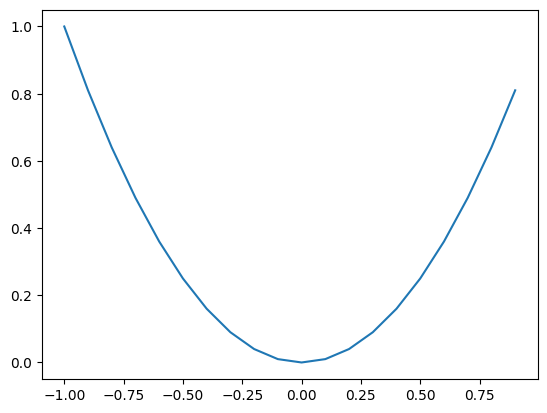

In [258]:
xs = np.arange(-1, 1, 0.1)
ys = xs**2

plt.plot(xs, ys)

In [259]:
xs_shaped = [[x] for x in xs]
xs_shaped

[[-1.0],
 [-0.9],
 [-0.8],
 [-0.7000000000000001],
 [-0.6000000000000001],
 [-0.5000000000000001],
 [-0.40000000000000013],
 [-0.30000000000000016],
 [-0.20000000000000018],
 [-0.1000000000000002],
 [-2.220446049250313e-16],
 [0.09999999999999964],
 [0.19999999999999973],
 [0.2999999999999998],
 [0.3999999999999997],
 [0.49999999999999956],
 [0.5999999999999996],
 [0.6999999999999997],
 [0.7999999999999996],
 [0.8999999999999995]]

In [272]:
def mse_loss(y_preds: list[Value], y_grnds: list[Value]):
    return sum([
        (y_pred - y_grnd)**2 
        for y_pred, y_grnd in zip(y_preds, y_grnds)
    ]) / len(y_preds)

nn = MLP(1, [10, 10, 1])

for i in range(1000):
  for p in nn.parameters():
      p.grad = 0.0

  loss.backward()

  for p in nn.parameters():
      p.data -= 0.01 * p.grad

  y_preds = [nn(x) for x in xs_shaped]
  loss = mse_loss(y_preds, ys)

y_preds

[Value(data=0.7136749617254146),
 Value(data=0.6697112061537608),
 Value(data=0.6118245129219421),
 Value(data=0.5381873759750051),
 Value(data=0.4487844740626463),
 Value(data=0.3468631232427318),
 Value(data=0.2396778917640216),
 Value(data=0.13751423994105566),
 Value(data=0.051157912524582586),
 Value(data=-0.01059087983231429),
 Value(data=-0.04191960690421091),
 Value(data=-0.039581444990628864),
 Value(data=-0.0021519568799030675),
 Value(data=0.0698852914692448),
 Value(data=0.17249748864703388),
 Value(data=0.2954423543962486),
 Value(data=0.4218090754215653),
 Value(data=0.5334166238468895),
 Value(data=0.6190181231259648),
 Value(data=0.6772300013902377)]

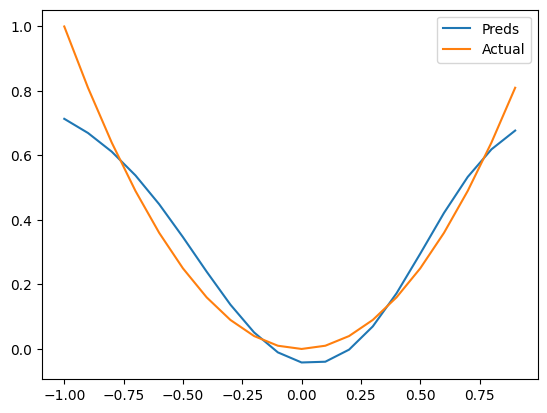

In [276]:
plt.plot(xs, [y.data for y in y_preds], label="Preds")
plt.plot(xs, ys, label="Actual")
plt.legend()
plt.show()